In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, root_mean_squared_error

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.common import load_data, Data


SELECTED_DATA= Data.FIRST_3000

In [2]:
df = load_data(SELECTED_DATA)

In [3]:
# Ver las dimensiones del DataFrame (filas y columnas)
print(f"Dimensiones del DataFrame: {df.shape}")

# Ver los nombres de las columnas y sus tipos de datos
print("\nInformación del DataFrame:")
display(df.info())  # display() para mejor presentación en notebooks

# Mostrar las primeras filas del DataFrame
print("\nPrimeras filas del DataFrame:")
print(df.head(10))

# # Resumen estadístico de los datos numéricos
print("\nResumen estadístico:")
display(df.describe())

Dimensiones del DataFrame: (3642173, 5)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642173 entries, 0 to 3642172
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 138.9 MB


None


Primeras filas del DataFrame:
   uid   d   t   x   y
0    0   0  25  75  82
1    0   0  24  76  86
2    0   0  22  81  89
3    0  18  13  86  97
4    0  18  12  85  97
5    0  18  11  81  88
6    0  17  36  77  86
7    0  17  35  79  84
8    0  17  34  77  86
9    0  17  33  77  86

Resumen estadístico:


,uid,d,t,x,y
count,3.642173e+06,3.642173e+06,3.642173e+06,3.642173e+06,3.642173e+06
mean,1.493830e+03,3.746488e+01,2.573454e+01,1.228730e+02,8.511531e+01
std,8.666647e+02,2.168419e+01,1.142356e+01,4.246668e+01,4.273534e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,7.450000e+02,1.900000e+01,1.700000e+01,9.400000e+01,5.700000e+01
50%,1.503000e+03,3.800000e+01,2.600000e+01,1.260000e+02,8.300000e+01
75%,2.246000e+03,5.700000e+01,3.500000e+01,1.560000e+02,1.110000e+02
max,2.999000e+03,7.400000e+01,4.700000e+01,2.000000e+02,2.000000e+02


In [4]:
def fill_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rellena los datos faltantes de usuario, día y timeslot.
    Asigna -1 a las coordenadas faltantes (x, y).

    Args:
        df (pd.DataFrame): DataFrame original con columnas ['uid', 'd', 't', 'x', 'y'].

    Returns:
        pd.DataFrame: DataFrame con datos completos (incluidos los faltantes).
    """
    # Determinar los rangos de uid, días y timeslots
    uids = df["uid"].unique()
    days = np.arange(df["d"].min(), df["d"].max() + 1)
    timeslots = np.arange(48)  # 48 time slots por día

    # Crear una base completa con todas las combinaciones de uid, día y timeslot
    complete_index = pd.MultiIndex.from_product(
        [uids, days, timeslots], names=["uid", "d", "t"]
    )
    complete_df = pd.DataFrame(index=complete_index).reset_index()

    # Combinar con los datos originales
    df = pd.merge(complete_df, df, on=["uid", "d", "t"], how="left")

    # Rellenar valores faltantes: asignar -1 a las coordenadas
    df["x"] = df["x"].fillna(-1)
    df["y"] = df["y"].fillna(-1)

    return df


def split_data(df: pd.DataFrame) -> tuple:
    """
    Divide los datos en entrenamiento, validación y prueba, asegurando 15 días adicionales
    para las secuencias de validación y prueba.
    """

    # Entrenamiento: datos antes del día 44
    train = df[df["d"] < 44]

    # Validación: incluye días desde el 37 (44 - 7) para construir las secuencias
    val = df[(df["d"] >= 37) & (df["d"] < 59)]

    # Prueba: incluye días desde el 52 (59 - 7) para construir las secuencias
    test = df[df["d"] >= 52]

    return train.copy(), val.copy(), test.copy()


def create_sequences(
    data: pd.DataFrame,
    columns,
    input_days=7,
    predict_days=7,
    times_per_day=48,
    for_day=True,
):
    """
    Crea las secuencias deslizantes para entrada y predicción.

    Args:
        data (pd.DataFrame): Datos completos con columnas ['x', 'y', 't', 'd'].
        input_days (int): Número de días de entrada.
        predict_days (int): Número de días a predecir.
        times_per_day (int): Cantidad de time slots por día.

    Returns:
        list of tuples: Lista de (input_seq, target_seq).
    """
    input_steps = input_days * times_per_day
    predict_steps = predict_days * times_per_day
    sequences = []

    # Convertir a numpy para mayor eficiencia
    data_array = data[columns].values

    # Crear la máscara (1 si no es 0, 0 si es 0)
    mask = (data_array != 0).astype(int)

    # Generar las ventanas deslizantes

    for idx in range(
        0, len(data) - input_steps - predict_steps, times_per_day if for_day else 1
    ):  # ventanas por dias
        # Secuencia de entrada (15 días)
        input_seq = data_array[idx : idx + input_steps]
        mask_seq = mask[idx : idx + input_steps]

        # Secuencia de salida (7 días)
        target_seq = data_array[
            idx + input_steps : idx + input_steps + predict_steps, :2
        ]  # Solo x, y
        mask_target = mask[idx + input_steps : idx + input_steps + predict_steps, :2]

        sequences.append((input_seq, target_seq, mask_seq, mask_target))

    return sequences


def get_scaler(df: pd.DataFrame, columns: list):
    """
    Ajusta un MinMaxScaler a las columnas especificadas del DataFrame y devuelve el scaler.

    Args:
        df (pd.DataFrame): DataFrame con los datos originales.
        columns (list): Lista de nombres de columnas a normalizar.

    Returns:
        scaler: Instancia ajustada de MinMaxScaler.
    """
    # Crear un scaler
    scaler = MinMaxScaler()

    # Ajustar el scaler a las columnas especificadas
    scaler.fit(df[columns])
    return scaler


def normalize_dataset(df: pd.DataFrame, scaler: MinMaxScaler, columns: list):
    """
    Normaliza las columnas especificadas de un DataFrame utilizando un MinMaxScaler ya ajustado.

    Args:
        df (pd.DataFrame): DataFrame con los datos originales.
        scaler (MinMaxScaler): Scaler ajustado con los datos de entrenamiento.
        columns (list): Lista de nombres de columnas a normalizar.

    Returns:
        pd.DataFrame: DataFrame normalizado
    """
    # Transformar las columnas especificadas con el scaler ajustado
    df[columns] = scaler.transform(df[columns])
    return df


def inverse_transform_predictions(

    predictions, scaler: MinMaxScaler, columns_to_desnormalize
):
    """
    Desnormaliza las predicciones del modelo usando el scaler ajustado.

    Args:
        predictions (torch.Tensor or np.ndarray): Predicciones normalizadas con forma (batch_size, sequence_length, num_features).
        scaler (MinMaxScaler): Scaler ajustado con los datos de entrada.
        columns_to_desnormalize (list): Índices de las columnas a desnormalizar (por ejemplo, [0, 1] para x, y).

    Returns:
        np.ndarray: Predicciones desnormalizadas con la misma forma que las predicciones originales.
    """
    # Si es un tensor de PyTorch, conviértelo a un numpy array
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    batch_size, sequence_length, num_features = predictions.shape

    # Crear un array desnormalizado con la misma forma que las predicciones
    desnormalized = np.zeros_like(predictions)

    # Desnormalizar cada elemento del batch
    for i in range(batch_size):
        # Extraer la predicción del batch actual (sequence_length, num_features)
        single_prediction = predictions[i]

        # Crear una matriz con el mismo número de columnas que el scaler original
        full_array = np.zeros((sequence_length, scaler.n_features_in_))

        # Insertar las predicciones en las columnas correspondientes
        full_array[:, columns_to_desnormalize] = single_prediction

        # Aplicar la transformación inversa
        full_array = scaler.inverse_transform(full_array)

        # Extraer las columnas desnormalizadas correspondientes
        desnormalized[i] = full_array[:, columns_to_desnormalize]

    return desnormalized

In [5]:
class GRU_Dataset(Dataset):
    def __init__(self, sequences):
        """
        Dataset que maneja las secuencias generadas de entrada, salida y máscara.

        Args:
            sequences (list of tuples): Lista de (input_seq, target_seq, mask_seq, mask_target_seq).
        """
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_seq, target_seq, mask_seq, mask_target_seq = self.sequences[idx]
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        target_seq = torch.tensor(target_seq, dtype=torch.float32)
        mask_seq = torch.tensor(mask_seq, dtype=torch.float32)
        mask_target_seq = torch.tensor(mask_target_seq, dtype=torch.float32)
        return input_seq, target_seq, mask_seq, mask_target_seq

In [6]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        """
        Modelo GRU para predicción de series temporales.

        Args:
            input_size (int): Número de características de entrada (e.g., 3: x, y, t).
            hidden_size (int): Dimensión del estado oculto de la GRU.
            output_size (int): Número de características de salida (e.g., 2: x, y).
            num_layers (int): Número de capas GRU.
            dropout (float): Dropout para regularización.
        """
        super(GRU_Model, self).__init__()
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada con forma (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: Predicciones con forma (batch_size, prediction_length, output_size).
        """
        # x -> (batch_size, sequence_length, input_size)
        out, _ = self.gru(x)  # out -> (batch_size, sequence_length, hidden_size)
        out = self.fc(out)  # out -> (batch_size, sequence_length, output_size)
        return out

In [7]:
def train_gru_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    learning_rate: float,
    device: torch.device,
):
    """
    Entrena el modelo GRU con un ciclo de entrenamiento y validación.

    Args:
        model (nn.Module): Modelo GRU.
        train_loader (DataLoader): DataLoader para entrenamiento.
        val_loader (DataLoader): DataLoader para validación.
        epochs (int): Número de épocas.
        learning_rate (float): Tasa de aprendizaje.
        device (torch.device): Dispositivo para computación (CPU/GPU).

    Returns:
        dict: Diccionario con:
            - 'best_model': Modelo con el mejor desempeño en validación.
            - 'train_losses': Lista de pérdidas de entrenamiento por época.
            - 'val_losses': Lista de pérdidas de validación por época.
            - 'best_epoch': Época con la menor pérdida de validación.
    """
    # Mover modelo a dispositivo
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss(
        reduction="none"
    )  # Usamos reducción personalizada para manejar máscaras

    best_model_weights = None
    best_val_loss = float("inf")  # Mejor pérdida de validación
    best_epoch = -1

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Modo de entrenamiento
        model.train()
        train_loss = 0.0

        for inputs, targets, masks_inputs, masks_targets in train_loader:
            # Mover datos a dispositivo
            inputs, targets, masks_targets = (
                inputs.to(device),
                targets.to(device),
                masks_targets.to(device),
            )

            # Forward
            optimizer.zero_grad()
            outputs = model(inputs)

            # Aplicar la máscara a la pérdida
            loss = criterion(outputs, targets)
            loss = (
                loss * masks_targets
            ).sum() / masks_targets.sum()  # Pérdida ponderada por la máscara

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, masks_inputs, masks_targets in val_loader:
                inputs, targets, masks_targets = (
                    inputs.to(device),
                    targets.to(device),
                    masks_targets.to(device),
                )
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss = (loss * masks_targets).sum() / masks_targets.sum()
                val_loss += loss.item()

        # Promedio de las pérdidas
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Guardar los pesos del mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_model_weights = copy.deepcopy(model.state_dict())  # Guardar los pesos

    print(
        f"\nEl mejor modelo se obtuvo en la época {best_epoch} con una pérdida de validación de {best_val_loss:.4f}."
    )

    # Cargar los mejores pesos en el modelo
    model.load_state_dict(best_model_weights)

    return {
        "best_model": model,  # Devuelve el modelo con los mejores pesos
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_epoch": best_epoch,
    }


def evaluate_model(
    model,
    data_loader,
    scaler,
    columns_to_desnormalize,
    device,
    dataset_name="Validación",
):
    """
    Evalúa el desempeño del modelo en un conjunto de datos (validación o prueba).

    Args:
        model (nn.Module): Modelo GRU entrenado.
        data_loader (DataLoader): DataLoader para el conjunto a evaluar.
        scaler (MinMaxScaler): Scaler ajustado con los datos de entrenamiento.
        columns_to_desnormalize (list): Columnas a desnormalizar.
        device (torch.device): Dispositivo de computación (CPU/GPU).
        dataset_name (str): Nombre del conjunto de datos (para identificar la evaluación).

    Returns:
        dict: Métricas de evaluación (MAE, RMSE, pérdida promedio).
    """
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    criterion = nn.MSELoss(
        reduction="none"
    )  # Usamos reducción 'none' para manejar máscaras

    with torch.no_grad():
        for inputs, targets, masks_inputs, masks_targets in data_loader:
            # Mover a dispositivo
            inputs, targets, masks_targets = (
                inputs.to(device),
                targets.to(device),
                masks_targets.to(device),
            )

            # Predicciones del modelo
            outputs = model(inputs)

            # Calcular la pérdida con la máscara
            loss = criterion(outputs, targets)
            loss = (loss * masks_targets).sum() / masks_targets.sum()
            total_loss += loss.item()

            # Desnormalizar las predicciones y valores reales
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs_desnormalized = inverse_transform_predictions(
                outputs, scaler, columns_to_desnormalize
            )
            targets_desnormalized = inverse_transform_predictions(
                targets, scaler, columns_to_desnormalize
            )

            # Convertir la máscara a NumPy
            masks_targets_numpy = masks_targets.cpu().numpy()

            # Aplicar la máscara para poner NaN en posiciones no válidas
            outputs_desnormalized[masks_targets_numpy == 0] = np.nan
            targets_desnormalized[masks_targets_numpy == 0] = np.nan

            # Almacenar para métricas globales
            all_predictions.append(outputs_desnormalized)
            all_targets.append(targets_desnormalized)

    # Concatenar todas las predicciones y objetivos (3D -> 2D)
    all_predictions = np.concatenate(all_predictions, axis=0).reshape(-1, 2)  # Aplanar
    all_targets = np.concatenate(all_targets, axis=0).reshape(-1, 2)  # Aplanar

    # Remover NaN introducidos por la máscara
    valid_indices = ~np.isnan(all_predictions[:, 0])
    all_predictions = all_predictions[valid_indices]
    all_targets = all_targets[valid_indices]

    # Calcular métricas usando NumPy o scikit-learn
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = root_mean_squared_error(all_targets, all_predictions)
    avg_loss = total_loss / len(data_loader)

    print(f"Resultados en {dataset_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - Loss: {avg_loss:.4f}")

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Loss": avg_loss,
        "Predictions": all_predictions,
        "Targets": all_targets,
    }

In [8]:
def evaluate_metrics_sequence(
    data, model, scaler,columns, device
):
    """
    Evalúa las métricas definidas en base a las predicciones generadas por el modelo para una sola secuencia.

    Args:
        data (pd.DataFrame): Dataset que contiene las columnas necesarias.
        model (nn.Module): Modelo GRU entrenado.
        scaler (MinMaxScaler): Scaler ajustado para normalización/desnormalización.
        metrics_instances (list): Lista de instancias de métricas (e.g., LPPMetric, MAEMetric, etc.).
        columns (list): Columnas necesarias para el modelo (e.g., ['x', 'y', 't', 'd']).
        device (torch.device): Dispositivo donde se ejecutará el modelo (CPU o GPU).

    Returns:
        dict: Resultados de las métricas calculadas.
    """
    model.eval()

    # Definir parámetros
    times_per_day = 48
    input_days = 7  # Días de entrada
    predict_days = 7  # Días de predicción

    # Crear la secuencia usando el primer día del dataset como referencia
    sequences = create_sequences(
        data,
        columns=columns,
        input_days=input_days,
        predict_days=predict_days,
        times_per_day=times_per_day,
        for_day=True,
    )

    # Solo necesitamos una secuencia
    input_seq, target_seq, mask_seq, mask_target = sequences[0]

    # Convertir a tensores
    input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)

    # Generar predicciones
    with torch.no_grad():
        predictions = model(input_tensor).cpu().numpy()

    # Desnormalizar las predicciones
    predictions_desnormalized = inverse_transform_predictions(
        predictions, scaler, [0, 1]  # Desnormalizamos las columnas `x` e `y`
    )

    # Reconstruir (d, t, x, y) para predicciones y targets, considerando solo los datos válidos por la máscara
    generated_sequences = []
    reference_sequences = []

    current_day = int(data["d"].iloc[0])  # Primer día del dataset
    current_timeslot = 0

    n_columns = scaler.n_features_in_
    for step_idx, (x_pred, y_pred) in enumerate(
        predictions_desnormalized[0]
    ):  # Batch único
        if mask_target[step_idx].sum() > 0:  # Considerar solo si la máscara lo permite
            day_offset = current_timeslot // times_per_day
            d = current_day + day_offset
            t = current_timeslot % times_per_day

            generated_sequences.append((d, t, x_pred, y_pred))

            # Target correspondiente (desnormalizar targets)
            x_true, y_true = target_seq[step_idx]
            # Creas un arreglo de ceros con el tamaño total de columnas
            features_array = np.zeros(n_columns)
            features_array[0] = x_true
            features_array[1] = y_true
            target_desnormalized = scaler.inverse_transform(
                [features_array]
            )  # Columna extra para mantener el tamaño
            x_true_desnormalized, y_true_desnormalized = target_desnormalized[0][:2]
            reference_sequences.append(
                (d, t, x_true_desnormalized, y_true_desnormalized)
            )

        current_timeslot += 1

    return generated_sequences, reference_sequences

In [9]:
df_fill = fill_missing_data(df)

### Cracteristicas `x`,`y`,`t` creando seuencias temporales diarias (Cada 48 timeslot)


In [10]:
COLUMNS = ["x", "y", "t"]

# Dividir los datos
train_data, val_data, test_data = split_data(df_fill)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Hiperparámetros
input_size = 3  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)

In [ ]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=learning_rate, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
nodel = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

Epoch 1/30, Train Loss: 0.0284, Val Loss: 0.0337
Epoch 2/30, Train Loss: 0.0229, Val Loss: 0.0332
Epoch 3/30, Train Loss: 0.0220, Val Loss: 0.0321
Epoch 4/30, Train Loss: 0.0210, Val Loss: 0.0306
Epoch 5/30, Train Loss: 0.0203, Val Loss: 0.0301
Epoch 6/30, Train Loss: 0.0199, Val Loss: 0.0301
Epoch 7/30, Train Loss: 0.0197, Val Loss: 0.0300
Epoch 8/30, Train Loss: 0.0196, Val Loss: 0.0300
Epoch 9/30, Train Loss: 0.0194, Val Loss: 0.0298
Epoch 10/30, Train Loss: 0.0193, Val Loss: 0.0298
Epoch 11/30, Train Loss: 0.0192, Val Loss: 0.0298
Epoch 12/30, Train Loss: 0.0191, Val Loss: 0.0299


In [13]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 25.0316
  - RMSE: 35.1591
  - Loss: 0.0311
Resultados en Prueba:
  - MAE: 24.3179
  - RMSE: 34.2927
  - Loss: 0.0296


In [ ]:
# Dataset normalizado
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric

# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

Resultados de las Métricas:
LPPMetric score: 0.0
MAEMetric score: 35.12685760606276
DTWMetric score: 335.68818623219903
GeoBLEUMetric score: 4.1855982843375785e-06


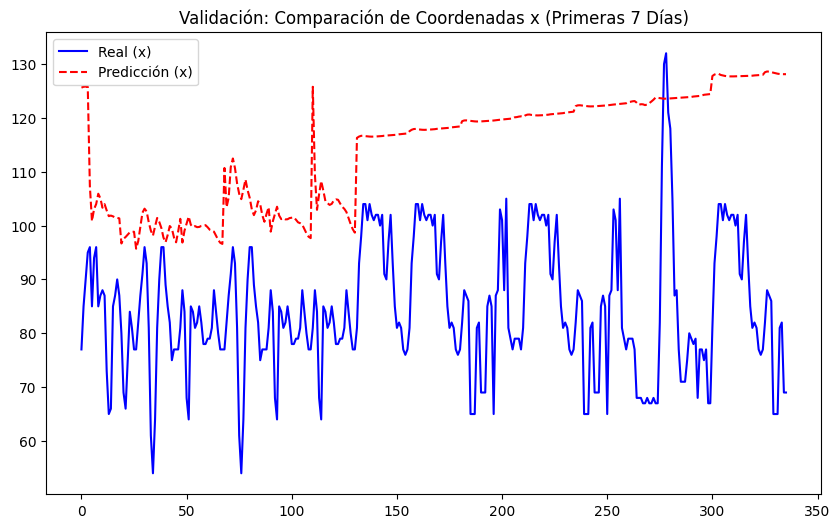

In [15]:
import matplotlib.pyplot as plt

# Predicciones y valores reales de validación
val_preds = val_metrics["Predictions"]
val_targets = val_metrics["Targets"]

plt.figure(figsize=(10, 6))
plt.plot(val_targets[:336, 0], label="Real (x)", color="blue")
plt.plot(val_preds[:336, 0], label="Predicción (x)", linestyle="--", color="red")
plt.title("Validación: Comparación de Coordenadas x (Primeras 7 Días)")
plt.legend()
plt.show()

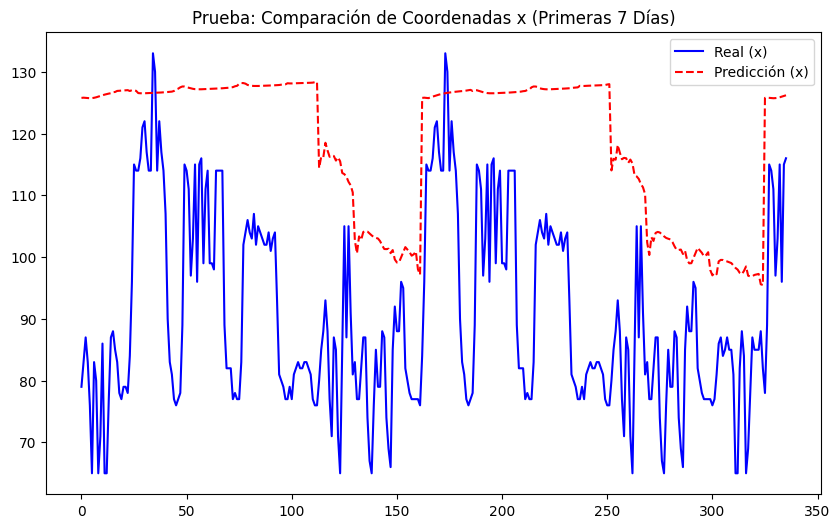

In [16]:
# Predicciones y valores reales de prueba
test_preds = test_metrics["Predictions"]
test_targets = test_metrics["Targets"]

plt.figure(figsize=(10, 6))
plt.plot(test_targets[:336, 0], label="Real (x)", color="blue")
plt.plot(test_preds[:336, 0], label="Predicción (x)", linestyle="--", color="red")
plt.title("Prueba: Comparación de Coordenadas x (Primeras 7 Días)")
plt.legend()
plt.show()

### Caracteristicas `x`,`y`,`t`,`day_of_week` donde `day_of_week` es el dia de la semana [0-6],con secuencias temporales de 1 dia ( cada 48 timeslots)


In [12]:
def add_feature(df: pd.DataFrame, feature: str, function):
    """
    Agrega una característica al DataFrame.

    Args:
        df (pd.DataFrame): DataFrame original.
        feature (str): Nombre de la característica a agregar.
        function: Función para calcular la característica.

    Returns:
        pd.DataFrame: DataFrame con la nueva característica.
    """
    df = df.copy()
    df[feature] = function(df)
    return df


def add_day_of_week(df: pd.DataFrame) -> pd.Series:
    """
    Calcula el día de la semana a partir de la columna 'd'.

    Args:
        df (pd.DataFrame): DataFrame con la columna 'd'.

    Returns:
        pd.Series: Día de la semana correspondiente a cada día.
    """
    return df["d"] % 7

In [18]:
df_day_of_week = add_feature(df_fill, "day_of_week", add_day_of_week)

COLUMNS = ["x", "y", "t", "day_of_week"]

# Dividir los datos
train_data, val_data, test_data = split_data(df_day_of_week)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
# Hiperparámetros
input_size = 4  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)

Epoch 1/20, Train Loss: 0.0191, Val Loss: 0.0304
Epoch 2/20, Train Loss: 0.0190, Val Loss: 0.0310
Epoch 3/20, Train Loss: 0.0189, Val Loss: 0.0308
Epoch 4/20, Train Loss: 0.0188, Val Loss: 0.0310
Epoch 5/20, Train Loss: 0.0187, Val Loss: 0.0312
Epoch 6/20, Train Loss: 0.0186, Val Loss: 0.0311
Epoch 7/20, Train Loss: 0.0186, Val Loss: 0.0312
Epoch 8/20, Train Loss: 0.0185, Val Loss: 0.0314
Epoch 9/20, Train Loss: 0.0184, Val Loss: 0.0314
Epoch 10/20, Train Loss: 0.0183, Val Loss: 0.0312
Epoch 11/20, Train Loss: 0.0183, Val Loss: 0.0316
Epoch 12/20, Train Loss: 0.0182, Val Loss: 0.0315
Epoch 13/20, Train Loss: 0.0181, Val Loss: 0.0316
Epoch 14/20, Train Loss: 0.0180, Val Loss: 0.0323
Epoch 15/20, Train Loss: 0.0180, Val Loss: 0.0320
Epoch 16/20, Train Loss: 0.0179, Val Loss: 0.0320
Epoch 17/20, Train Loss: 0.0178, Val Loss: 0.0326
Epoch 18/20, Train Loss: 0.0177, Val Loss: 0.0327
Epoch 19/20, Train Loss: 0.0176, Val Loss: 0.0324
Epoch 20/20, Train Loss: 0.0175, Val Loss: 0.0332

El mejor

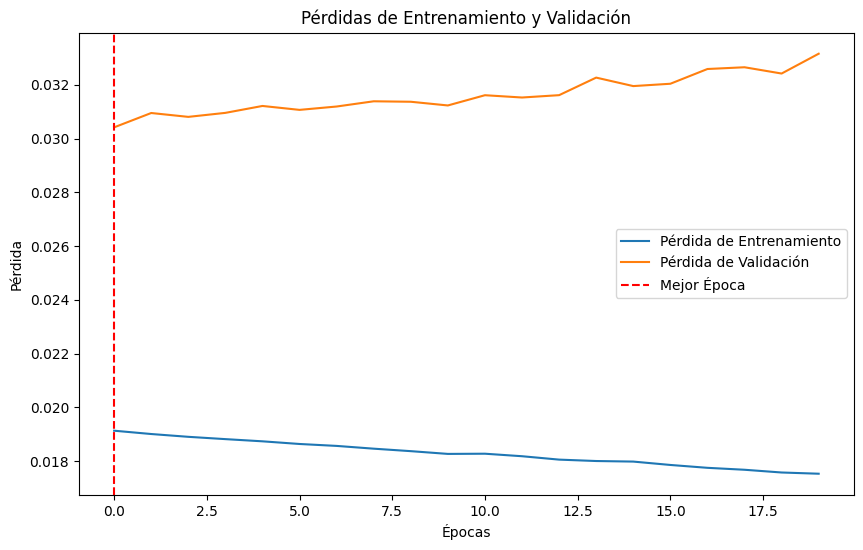

In [24]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=0.001, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
model = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [25]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 24.2341
  - RMSE: 34.7727
  - Loss: 0.0304
Resultados en Prueba:
  - MAE: 24.1732
  - RMSE: 34.5318
  - Loss: 0.0300


In [30]:
# Dataset normalizado
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric

# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

Resultados de las Métricas:
LPPMetric score: 1.8518518518518516
MAEMetric score: 35.042247330034776
DTWMetric score: 337.13341194977824
GeoBLEUMetric score: 0.0005401077952171091


### Caracteristicas `x`,`y`,`delta_t` donde `delta_t` es la cantidad de timeslot que no se dio ping entre el anterior y actual ping,con secuencias temporales de 1 dia ( cada 48 timeslots)


In [10]:
def fill_missing_data_with_features(
    df: pd.DataFrame, additional_features: list = None
) -> pd.DataFrame:
    """
    Rellena los datos faltantes de usuario, día y timeslot, y maneja características adicionales.
    Asigna -1 a los valores faltantes en las coordenadas (x, y) y en cualquier característica adicional.

    Args:
        df (pd.DataFrame): DataFrame original con columnas ['uid', 'd', 't', 'x', 'y'] y posibles características adicionales.
        additional_features (list): Lista de características adicionales a incluir en el DataFrame.

    Returns:
        pd.DataFrame: DataFrame con datos completos (incluidos los faltantes).
    """
    if additional_features is None:
        additional_features = []

    # Determinar los rangos de uid, días y timeslots
    uids = df["uid"].unique()
    days = np.arange(df["d"].min(), df["d"].max() + 1)
    timeslots = np.arange(48)  # 48 time slots por día

    # Crear una base completa con todas las combinaciones de uid, día y timeslot
    complete_index = pd.MultiIndex.from_product(
        [uids, days, timeslots], names=["uid", "d", "t"]
    )
    complete_df = pd.DataFrame(index=complete_index).reset_index()

    # Combinar con los datos originales
    df = pd.merge(complete_df, df, on=["uid", "d", "t"], how="left")

    # Rellenar valores faltantes para las coordenadas
    df["x"] = df["x"].fillna(-1)
    df["y"] = df["y"].fillna(-1)

    # Rellenar valores faltantes para las características adicionales
    for feature in additional_features:
        if feature not in df.columns:
            # Si la característica no existe en el DataFrame, agregarla con -1
            df[feature] = -1
        else:
            # Rellenar valores faltantes con -1
            df[feature] = df[feature].fillna(-1)

    return df

In [13]:
def add_delta_t(df: pd.DataFrame) -> pd.Series:
    """
    Calcula el delta de timeslots entre observaciones consecutivas considerando días diferentes.

    Args:
        df (pd.DataFrame): DataFrame con columnas `d` (día) y `t` (timeslot dentro del día).

    Returns:
        pd.Series: Serie con los valores de delta_t (cantidad de timeslots sin ping entre observaciones).
    """
    deltas = []
    for i in range(len(df)):
        if i == 0:  # Primer registro no tiene delta
            deltas.append(0)
        else:
            # Calcular el delta considerando días
            current_day, current_t = df.iloc[i]["d"], df.iloc[i]["t"]
            prev_day, prev_t = df.iloc[i - 1]["d"], df.iloc[i - 1]["t"]

            if current_day == prev_day:
                # Mismo día: diferencia simple de timeslots
                delta = current_t - prev_t
            else:
                # Días diferentes: incluir los slots del día anterior y el siguiente
                slots_from_prev_day = 48 - prev_t
                slots_from_current_day = current_t
                delta = (
                    slots_from_prev_day
                    + slots_from_current_day
                    + (current_day - prev_day - 1) * 48
                )

            deltas.append(delta)

    return pd.Series(deltas)


df_delta = add_feature(df, "delta_t", add_delta_t)

fill_data = fill_missing_data_with_features(df_delta, ["delta_t"])

COLUMNS = ["x", "y", "delta_t"]

# Dividir los datos
train_data, val_data, test_data = split_data(fill_data)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Hiperparámetros
input_size = 3  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)

Epoch 1/10, Train Loss: 0.0278, Val Loss: 0.0337
Epoch 2/10, Train Loss: 0.0227, Val Loss: 0.0332
Epoch 3/10, Train Loss: 0.0220, Val Loss: 0.0321
Epoch 4/10, Train Loss: 0.0209, Val Loss: 0.0308
Epoch 5/10, Train Loss: 0.0202, Val Loss: 0.0303
Epoch 6/10, Train Loss: 0.0199, Val Loss: 0.0303
Epoch 7/10, Train Loss: 0.0197, Val Loss: 0.0301
Epoch 8/10, Train Loss: 0.0196, Val Loss: 0.0301
Epoch 9/10, Train Loss: 0.0195, Val Loss: 0.0304
Epoch 10/10, Train Loss: 0.0194, Val Loss: 0.0298

El mejor modelo se obtuvo en la época 10 con una pérdida de validación de 0.0298.


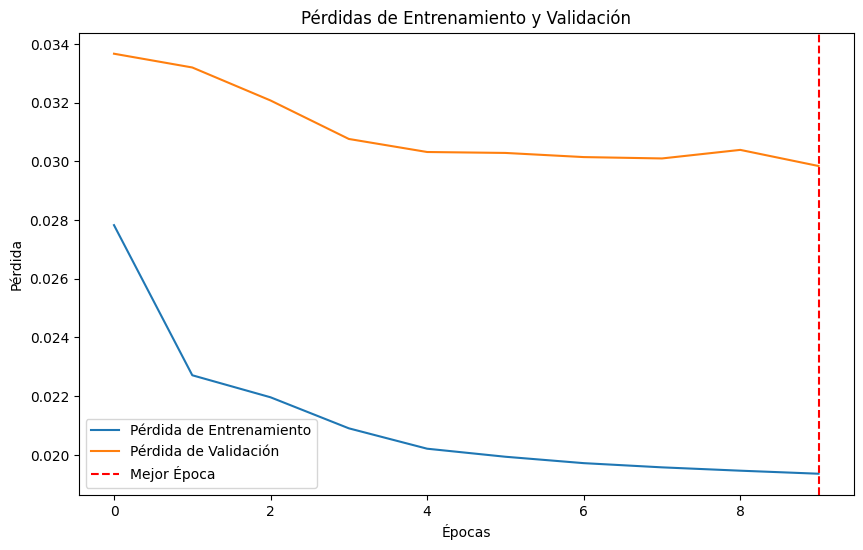

In [17]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=0.001, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
model = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [18]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 23.8188
  - RMSE: 34.4346
  - Loss: 0.0298


KeyboardInterrupt: 

In [ ]:
# Dataset normalizado
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric

# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

### Caracteristicas `x`,`y`,`delta_t`,`day_of_week` donde `day_of_week` es el dia de la semana [0-6] y `delta_t` es la cantidad de timeslot que no se dio ping entre el anterior y actual ping, con secuencias temporales de 1 dia ( cada 48 timeslots)


In [21]:
def add_delta_t(df: pd.DataFrame) -> pd.Series:
    """
    Calcula el delta de timeslots entre observaciones consecutivas considerando días diferentes.

    Args:
        df (pd.DataFrame): DataFrame con columnas `d` (día) y `t` (timeslot dentro del día).

    Returns:
        pd.Series: Serie con los valores de delta_t (cantidad de timeslots sin ping entre observaciones).
    """
    deltas = []
    for i in range(len(df)):
        if i == 0:  # Primer registro no tiene delta
            deltas.append(0)
        else:
            # Calcular el delta considerando días
            current_day, current_t = df.iloc[i]["d"], df.iloc[i]["t"]
            prev_day, prev_t = df.iloc[i - 1]["d"], df.iloc[i - 1]["t"]

            if current_day == prev_day:
                # Mismo día: diferencia simple de timeslots
                delta = current_t - prev_t
            else:
                # Días diferentes: incluir los slots del día anterior y el siguiente
                slots_from_prev_day = 48 - prev_t
                slots_from_current_day = current_t
                delta = (
                    slots_from_prev_day
                    + slots_from_current_day
                    + (current_day - prev_day - 1) * 48
                )

            deltas.append(delta)

    return pd.Series(deltas)


df_delta = add_feature(df, "delta_t", add_delta_t)

fill_data = fill_missing_data_with_features(df_delta, ["delta_t"])

df_day_of_week_delta_t = add_feature(fill_data, "day_of_week", add_day_of_week)

COLUMNS = ["x", "y", "delta_t", "day_of_week"]

# Dividir los datos
train_data, val_data, test_data = split_data(df_day_of_week_delta_t)

# Ajustar el scaler a los datos de entrenamiento
scaler = get_scaler(train_data, COLUMNS)

# Normalizar los datos solamnete con l scaler del train
train_data = normalize_dataset(train_data, scaler, COLUMNS)
val_data = normalize_dataset(val_data, scaler, COLUMNS)
test_data = normalize_dataset(test_data, scaler, COLUMNS)

# Crear las secuencias para cada conjunto
train_sequences = create_sequences(train_data, COLUMNS)
val_sequences = create_sequences(val_data, COLUMNS)
test_sequences = create_sequences(test_data, COLUMNS)

# Crear datasets
train_dataset = GRU_Dataset(train_sequences)
val_dataset = GRU_Dataset(val_sequences)
test_dataset = GRU_Dataset(test_sequences)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Hiperparámetros
input_size = 4  # Número de características de entrada: x, y, t
hidden_size = 128  # Tamaño del estado oculto de la GRU
output_size = 2  # Predicción de x, y
num_layers = 3  # Capas GRU
dropout = 0.2  # Dropout para regularización


model = GRU_Model(input_size, hidden_size, output_size, num_layers, dropout)

Epoch 1/50, Train Loss: 0.1370, Val Loss: 0.1505
Epoch 2/50, Train Loss: 0.0979, Val Loss: 0.0596
Epoch 3/50, Train Loss: 0.0552, Val Loss: 0.0397
Epoch 4/50, Train Loss: 0.0354, Val Loss: 0.0389
Epoch 5/50, Train Loss: 0.0371, Val Loss: 0.0328
Epoch 6/50, Train Loss: 0.0316, Val Loss: 0.0322
Epoch 7/50, Train Loss: 0.0336, Val Loss: 0.0300
Epoch 8/50, Train Loss: 0.0317, Val Loss: 0.0302
Epoch 9/50, Train Loss: 0.0309, Val Loss: 0.0307
Epoch 10/50, Train Loss: 0.0325, Val Loss: 0.0297
Epoch 11/50, Train Loss: 0.0309, Val Loss: 0.0300
Epoch 12/50, Train Loss: 0.0313, Val Loss: 0.0295
Epoch 13/50, Train Loss: 0.0310, Val Loss: 0.0291
Epoch 14/50, Train Loss: 0.0302, Val Loss: 0.0285
Epoch 15/50, Train Loss: 0.0297, Val Loss: 0.0273
Epoch 16/50, Train Loss: 0.0286, Val Loss: 0.0272
Epoch 17/50, Train Loss: 0.0319, Val Loss: 0.0261
Epoch 18/50, Train Loss: 0.0300, Val Loss: 0.0258
Epoch 19/50, Train Loss: 0.0258, Val Loss: 0.0281
Epoch 20/50, Train Loss: 0.0334, Val Loss: 0.0316
Epoch 21/

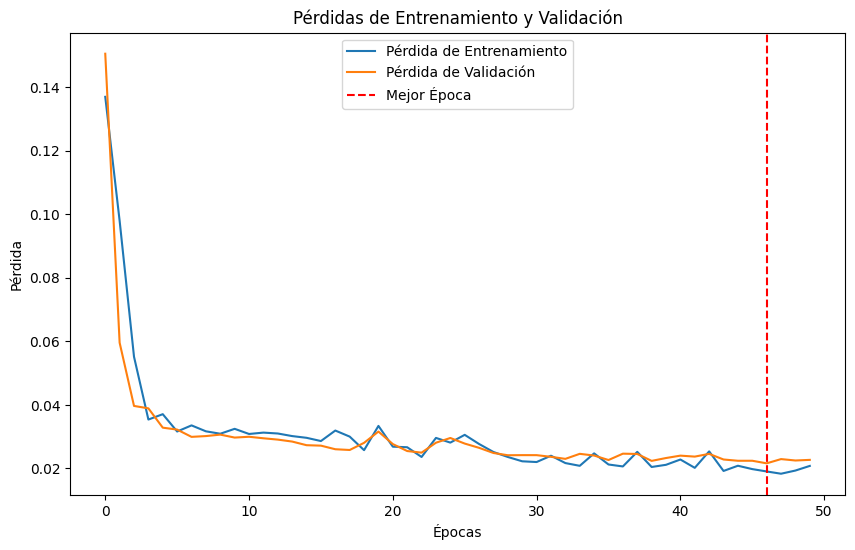

In [23]:
# Hiperparámetros
epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el modelo
# Entrenar el modelo
results = train_gru_model(
    model, train_loader, val_loader, epochs=epochs, learning_rate=0.001, device=device
)

# Extraer los datos del entrenamiento
train_losses = results["train_losses"]
val_losses = results["val_losses"]
best_epoch = results["best_epoch"]
model = results["best_model"]

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Pérdida de Entrenamiento")
plt.plot(val_losses, label="Pérdida de Validación")
plt.axvline(best_epoch - 1, color="red", linestyle="--", label="Mejor Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdidas de Entrenamiento y Validación")
plt.legend()
plt.show()

In [24]:
# Evaluar en validación
val_metrics = evaluate_model(
    model, val_loader, scaler, [0, 1], device, dataset_name="Validación"
)

# Evaluar en prueba
test_metrics = evaluate_model(
    model, test_loader, scaler, [0, 1], device, dataset_name="Prueba"
)

Resultados en Validación:
  - MAE: 17.9341
  - RMSE: 23.5326
  - Loss: 0.0227
Resultados en Prueba:
  - MAE: 17.3826
  - RMSE: 23.1904
  - Loss: 0.0199


In [ ]:
# Dataset normalizado
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric

# Instancias de métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    DTWMetric(),
    GeoBLEUMetric(),
]

# Evaluar las métricas a partir del día 60
generated_sequences, reference_sequences = evaluate_metrics_sequence(
    test_data,
    model,
    scaler,
    columns=COLUMNS,
    device=device,
)

# Calcular métricas
results = {}
for metric in metrics_instances:
    metric_name = type(metric).__name__
    results[metric_name] = metric.calculate([generated_sequences], [reference_sequences])

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")